In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import shutil
from tqdm import tqdm  #visualize loop
from datetime import date
import zipfile
import time
#import geodatasets

import warnings
warnings.filterwarnings("ignore")
# Preprocessing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# Regression model
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

# import pickle
import dill
import pickle
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
# Neural net
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten





In [2]:
#pip install xgboost

In [3]:
#pip install dill

## Building the dataset

In [4]:
# Import the weather dataframe from Wildfire_allstation_extraction.ipynb
weather = pd.read_csv('dataset/Weather_all_data.csv')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826270 entries, 0 to 1826269
Data columns (total 34 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   Longitude (x)              float64
 2   Latitude (y)               float64
 3   Station Name               object 
 4   Climate ID                 object 
 5   Date/Time                  object 
 6   Year                       int64  
 7   Month                      int64  
 8   Day                        int64  
 9   Data Quality               object 
 10  Max Temp (°C)              float64
 11  Max Temp Flag              object 
 12  Min Temp (°C)              float64
 13  Min Temp Flag              object 
 14  Mean Temp (°C)             float64
 15  Mean Temp Flag             object 
 16  Heat Deg Days (°C)         float64
 17  Heat Deg Days Flag         object 
 18  Cool Deg Days (°C)         float64
 19  Cool Deg Days Flag         object 
 20  To

In [5]:
# Adding season feature
# splitting month in season:
season = {1:[12,1,2], 2:[3,4,5], 3:[6,7,8], 4:[9,10,11]}
season1 = {'Winter':[12,1,2], 'Spring':[3,4,5], 'Summer':[6,7,8], 'Fall':[9,10,11]}

# Function to map the season in the dataframe:
def map_season(month):
    for key, value in season.items():
        if month in value:
            return key
        
def map_season1(month):
    for key, value in season1.items():
        if month in value:
            return key


weather['Season_num'] = weather['Month'].apply(map_season)
weather['Season'] = weather['Month'].apply(map_season1)

In [6]:
weather['Province'].value_counts()

Province
ALBERTA                  414729
BRITISH COLUMBIA         321552
QUEBEC                   294147
ONTARIO                  242991
SASKATCHEWAN             131544
MANITOBA                 100485
NOVA SCOTIA               65772
NUNAVUT                   63945
NEWFOUNDLAND              60291
NORTHWEST TERRITORIES     49329
NEW BRUNSWICK             39464
YUKON TERRITORY           27405
PRINCE EDWARD ISLAND      14616
Name: count, dtype: int64

In [7]:
# Validation of duplicate value
print(weather.shape)
print(weather[['Station Name','StationId','Year','Month','Day']].drop_duplicates().shape)

(1826270, 36)
(1826270, 5)


In [8]:
# Adding elevation
df = pd.read_csv('data/Station Inventory EN.csv', skiprows=3)
elev = df[['Station ID','Elevation (m)']].rename({'Station ID':'StationId'}, axis=1)

In [9]:
# load missing values per station that was loaded
missing = pd.read_csv('dataset/CONCAT_resultdf.csv')
missing = missing.rename({'Station ID':'StationId'}, axis=1)
missing1 = missing.drop(['Unnamed: 0','Province','Min_Year','Max_Year','error'], axis=1)
missing1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   StationId      1439 non-null   int64  
 1   Status         1439 non-null   bool   
 2   Null pourcent  1439 non-null   float64
dtypes: bool(1), float64(1), int64(1)
memory usage: 24.0 KB


In [10]:
weather1 = weather.merge(missing1, how='left', on='StationId')
weather1 = weather1[['Province','StationId','Station Name','Longitude (x)', 'Latitude (y)','Year','Season','Season_num',
                    'Month', 'Day','Max Temp (°C)','Min Temp (°C)','Mean Temp (°C)','Total Precip (mm)']]
weather1 = weather1.merge(elev, how='left', on='StationId')
weather1['Date'] = pd.to_datetime(weather1[['Year', 'Month', 'Day']])
weather1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826270 entries, 0 to 1826269
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Province           object        
 1   StationId          int64         
 2   Station Name       object        
 3   Longitude (x)      float64       
 4   Latitude (y)       float64       
 5   Year               int64         
 6   Season             object        
 7   Season_num         int64         
 8   Month              int64         
 9   Day                int64         
 10  Max Temp (°C)      float64       
 11  Min Temp (°C)      float64       
 12  Mean Temp (°C)     float64       
 13  Total Precip (mm)  float64       
 14  Elevation (m)      float64       
 15  Date               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(5), object(3)
memory usage: 222.9+ MB


## Preprocessing

In [11]:
# Creating the csv file containg Weather station information for the model prediction in Streamlit
df = pd.read_csv('data/Station Inventory EN.csv', skiprows=3)
df = df.loc[df['DLY Last Year'] > 2020].reset_index(drop=True)
df = df.rename({'Station ID':'StationId', 'Latitude (Decimal Degrees)':'Latitude (y)','Longitude (Decimal Degrees)':'Longitude (x)','Name':'Station Name'}, axis=1)
df_station = df.merge(missing1, how='left', on='StationId')
df_station = df_station.drop(['WMO ID', 'TC ID','HLY First Year', 'HLY Last Year', 'DLY First Year', 'DLY Last Year',
        'MLY First Year', 'MLY Last Year','Latitude',
        'Longitude'], axis=1)
df_station = df_station.dropna().reset_index(drop=True)  # for missing elevation
df_station.info()
df_station.to_csv('Station_info_all.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station Name   1432 non-null   object 
 1   Province       1432 non-null   object 
 2   Climate ID     1432 non-null   object 
 3   StationId      1432 non-null   int64  
 4   Latitude (y)   1432 non-null   float64
 5   Longitude (x)  1432 non-null   float64
 6   Elevation (m)  1432 non-null   float64
 7   First Year     1432 non-null   int64  
 8   Last Year      1432 non-null   int64  
 9   Status         1432 non-null   bool   
 10  Null pourcent  1432 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 113.4+ KB


In [12]:
df_station

,Station Name,Province,Climate ID,StationId,Latitude (y),Longitude (x),Elevation (m),First Year,Last Year,Status,Null pourcent
0,CHEMAINUS,BRITISH COLUMBIA,1011500,26,48.94,-123.74,75.00,1919,2023,True,2.152560
1,LAKE COWICHAN,BRITISH COLUMBIA,1012055,40,48.83,-124.05,171.00,1960,2023,False,45.559039
2,DISCOVERY ISLAND,BRITISH COLUMBIA,1012475,27226,48.42,-123.23,18.93,1997,2023,False,33.667712
3,ESQUIMALT HARBOUR,BRITISH COLUMBIA,1012710,52,48.43,-123.44,3.00,1957,2023,True,3.824451
4,GALIANO NORTH,BRITISH COLUMBIA,10130MN,55,48.99,-123.57,6.00,1975,2021,False,80.710554
...,...,...,...,...,...,...,...,...,...,...,...
1427,MARY'S HARBOUR A,NEWFOUNDLAND,8502592,51918,52.30,-55.85,10.60,2013,2023,True,10.401003
1428,NAIN,NEWFOUNDLAND,8502799,10813,56.55,-61.68,7.60,1994,2023,False,56.265664
1429,NAIN A,NEWFOUNDLAND,8502810,53502,56.55,-61.68,6.40,2015,2023,False,37.969925
1430,SAGLEK,NEWFOUNDLAND,8503249,6797,58.48,-62.59,488.00,1989,2023,False,77.380952


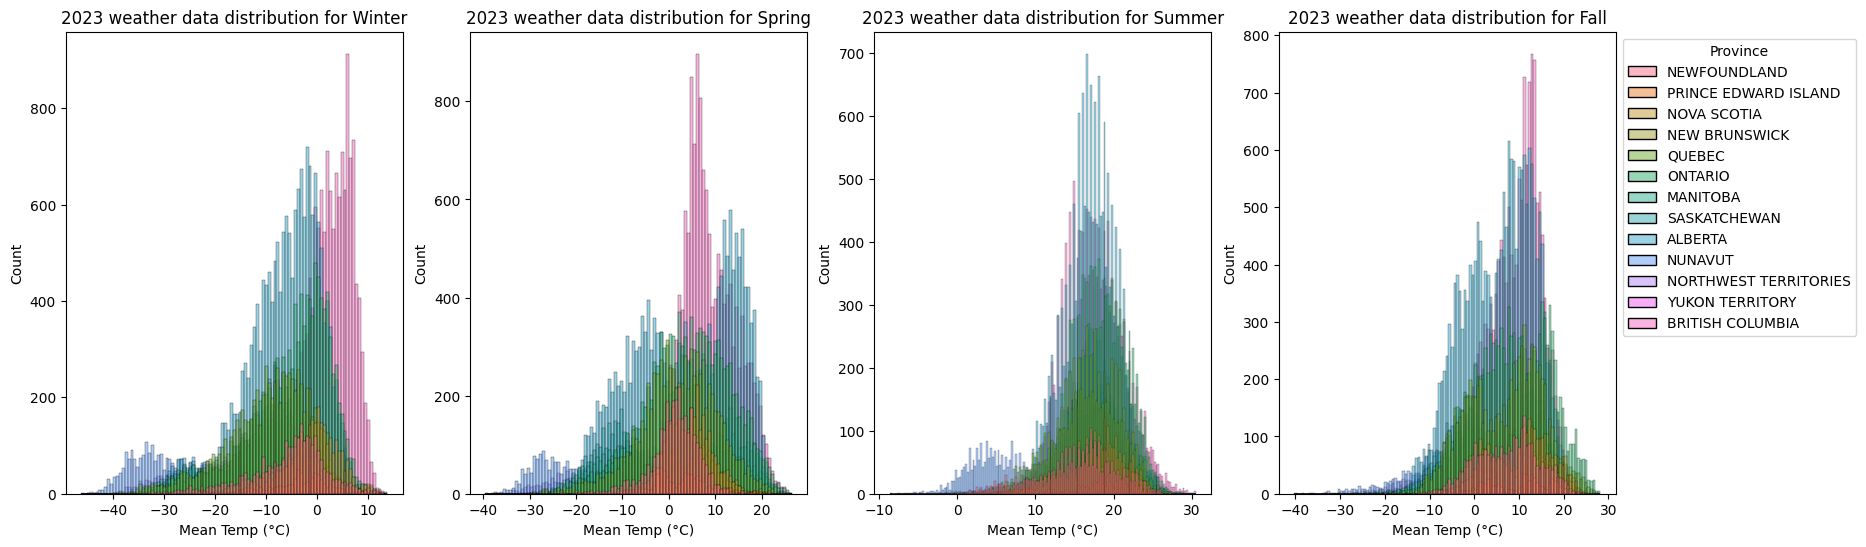

In [13]:
vis = weather1.loc[weather1['Year'] == 2023]
i = 1
plt.figure(figsize=(20,6))
for seas in weather1['Season'].unique():
    vis1 = vis.loc[vis['Season']==seas]
    if i !=4:
        plt.subplot(1,4,i)
        ax = sns.histplot(data=vis1, x='Mean Temp (°C)', hue='Province', legend=False)
        plt.title(f'2023 weather data distribution for {seas}')
        i+=1
    else:
        plt.subplot(1,4,i)
        ax = sns.histplot(data=vis1, x='Mean Temp (°C)', hue='Province', legend=True)
        plt.title(f'2023 weather data distribution for {seas}')
        sns.move_legend(ax,loc="upper left", bbox_to_anchor=(1, 1))

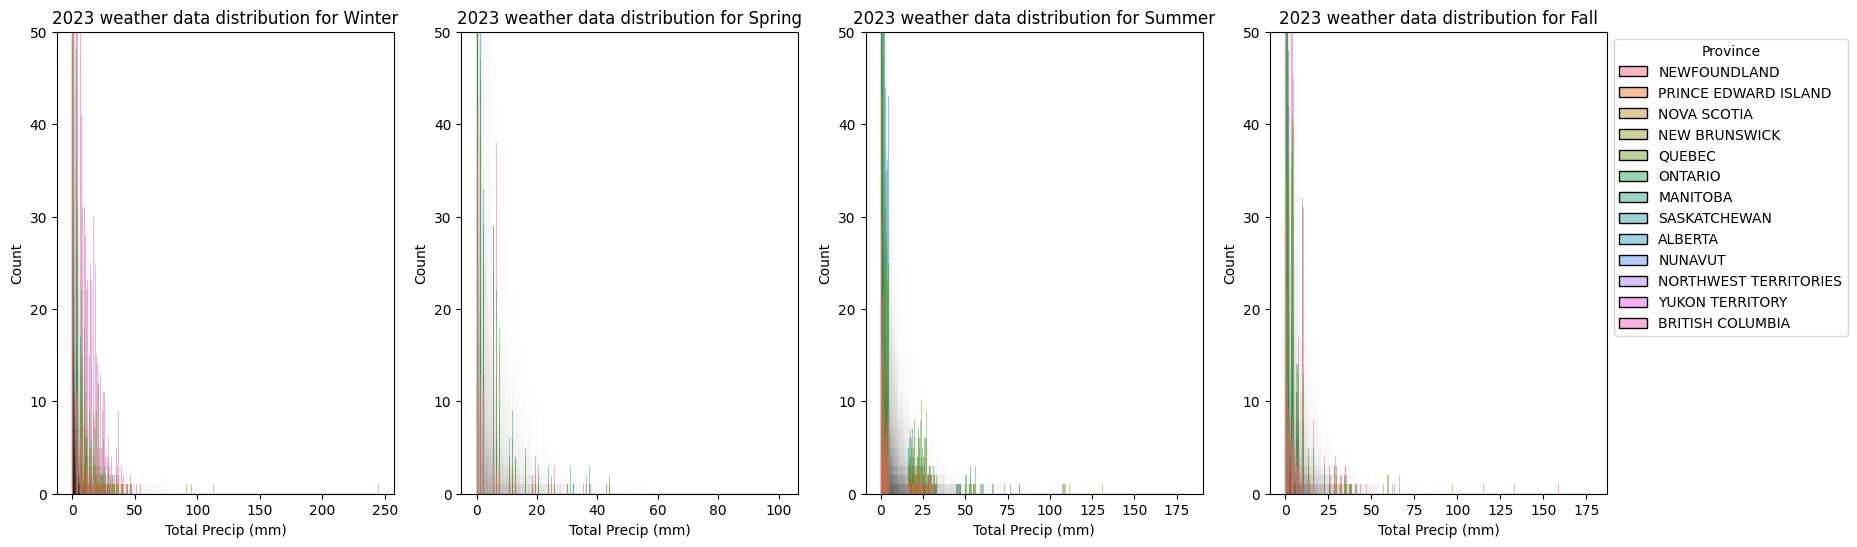

In [14]:
vis = weather1.loc[weather1['Year'] == 2023]
i = 1
plt.figure(figsize=(20,6))
for seas in weather1['Season'].unique():
    vis1 = vis.loc[vis['Season']==seas]
    if i !=4:
        plt.subplot(1,4,i)
        ax = sns.histplot(data=vis1, x='Total Precip (mm)', hue='Province', legend=False)
        plt.ylim(0, 50)
        plt.title(f'2023 weather data distribution for {seas}')
        i+=1
    else:
        plt.subplot(1,4,i)
        ax = sns.histplot(data=vis1, x='Total Precip (mm)', hue='Province', legend=True)
        plt.title(f'2023 weather data distribution for {seas}')
        plt.ylim(0, 50)
        sns.move_legend(ax,loc="upper left", bbox_to_anchor=(1, 1))

In [15]:
# Preprocessing loop for models training
categorical = ['Province','Season']
ordinal = ['Month','Year','Day', 'Season_num']
continuous = ['Longitude (x)','Latitude (y)','Elevation (m)']
numerical = continuous+ordinal
drop = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)','Total Precip (mm)', 'Station Name']
season_list = list(weather1['Season'].unique())
province_list = list(weather1['Province'].unique())

dict_columns = {'Categorical':categorical,
                'Ordinal':ordinal, 
                'Continuous':continuous,
                'Numerical':numerical,
                'drop':drop}

weather_dropna = weather1.dropna().reset_index(drop=True)
data = weather_dropna.drop(drop, axis=1)
predictions = weather_dropna[['Max Temp (°C)', 'Mean Temp (°C)','Min Temp (°C)', 'Total Precip (mm)']]
pred_list = predictions.columns

# For encoding 
def custom_combiner(feature, category):
     '''
     Function to create concatenate column name for the encoder
     :param[feature]: Column names containing the features for the encoder
     :param[category]: Categories in each columns for the encoder
     ...
     :return: the concatenation of the feature and category
     :rtype: string
     '''
     return str(feature) + "_" + str(category)

encoder = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop='first')
data_encode = encoder.fit_transform(data[categorical])
columns_encode = encoder.get_feature_names_out()
data_pre = data.drop(categorical, axis=1)
data_pre = data_pre.join(pd.DataFrame(data=data_encode, columns=columns_encode))


## For scaling
scaler = StandardScaler()
data_pre[numerical]= scaler.fit_transform(data_pre[numerical])
data_pre


,StationId,Longitude (x),Latitude (y),Year,Season_num,Month,Day,Elevation (m),Date,Province_BRITISH COLUMBIA,...,Province_NOVA SCOTIA,Province_NUNAVUT,Province_ONTARIO,Province_PRINCE EDWARD ISLAND,Province_QUEBEC,Province_SASKATCHEWAN,Province_YUKON TERRITORY,Season_Spring,Season_Summer,Season_Winter
0,52541,1.465572,0.253870,1.798845,-1.290246,-1.502696,-1.666985,0.460937,2024-01-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,52541,1.465572,0.253870,1.798845,-1.290246,-1.502696,-1.553314,0.460937,2024-01-02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,52541,1.465572,0.253870,1.798845,-1.290246,-1.502696,-1.439643,0.460937,2024-01-03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,52541,1.465572,0.253870,1.798845,-1.290246,-1.502696,-1.325973,0.460937,2024-01-04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,52541,1.465572,0.253870,1.798845,-1.290246,-1.502696,-1.212302,0.460937,2024-01-05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323806,26,-1.117533,-0.428999,-1.354479,-1.290246,1.655866,1.288452,-0.926516,2020-12-27,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1323807,26,-1.117533,-0.428999,-1.354479,-1.290246,1.655866,1.402122,-0.926516,2020-12-28,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1323808,26,-1.117533,-0.428999,-1.354479,-1.290246,1.655866,1.515793,-0.926516,2020-12-29,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1323809,26,-1.117533,-0.428999,-1.354479,-1.290246,1.655866,1.629464,-0.926516,2020-12-30,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323811 entries, 0 to 1323810
Data columns (total 24 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   StationId                       1323811 non-null  int64         
 1   Longitude (x)                   1323811 non-null  float64       
 2   Latitude (y)                    1323811 non-null  float64       
 3   Year                            1323811 non-null  float64       
 4   Season_num                      1323811 non-null  float64       
 5   Month                           1323811 non-null  float64       
 6   Day                             1323811 non-null  float64       
 7   Elevation (m)                   1323811 non-null  float64       
 8   Date                            1323811 non-null  datetime64[ns]
 9   Province_BRITISH COLUMBIA       1323811 non-null  float64       
 10  Province_MANITOBA               1323811 no

## Linear regression models

### Visualization of predictors 

In [17]:
# Linear model on total precipitation
features = ['Season_num','Month','Longitude (x)',
            'Year','Day','Latitude (y)', 'Elevation (m)']
to_pred = 'Max Temp (°C)'
X = weather_dropna[features]
y = weather_dropna[to_pred]

# Creating a function to plot feature vs price and the prediction
def reg_plot_on_graph(X, y, param, degree, ax, to_pred):
    if degree == 1:
        Xfit = sm.add_constant(X[param])

    else:
        Xfit = sm.add_constant(X[param])
        for i in range(2,degree+1):
            X_add = pd.DataFrame(np.power(X[param], i))
            X_add = X_add.rename(columns={param:param + 'poly'+str(degree)})
            Xfit = pd.concat([Xfit, X_add], axis=1)
    
    model = sm.OLS(y, Xfit).fit()
    yfit = model.predict(Xfit)
    
    ax.scatter(X[param], y)
    ax.scatter(Xfit[param], yfit, color='orange')
    ax.set_ylabel(to_pred)
    ax.set_xlabel(f'{param}')

    return

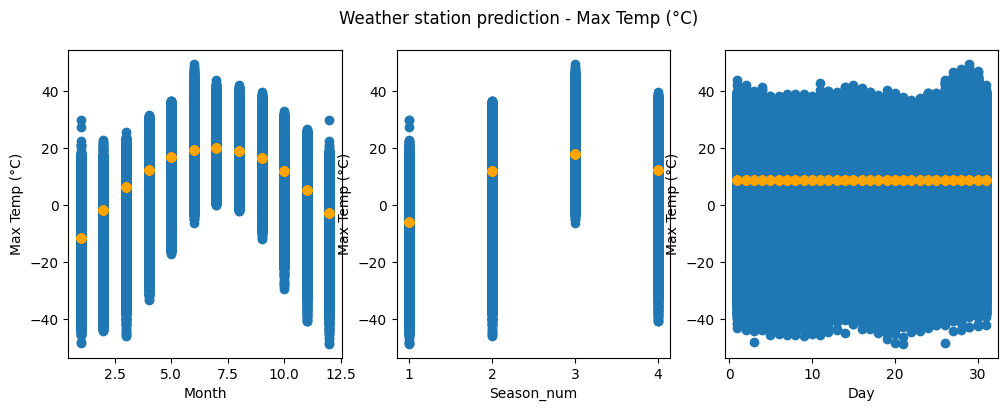

In [18]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize= (12,4))
reg_plot_on_graph(X,y,'Month', 2, ax1,to_pred)
reg_plot_on_graph(X,y,'Season_num', 2, ax2,to_pred)
reg_plot_on_graph(X,y,'Day', 1, ax3,to_pred)
fig.suptitle(f'Weather station prediction - {to_pred}')
plt.show()

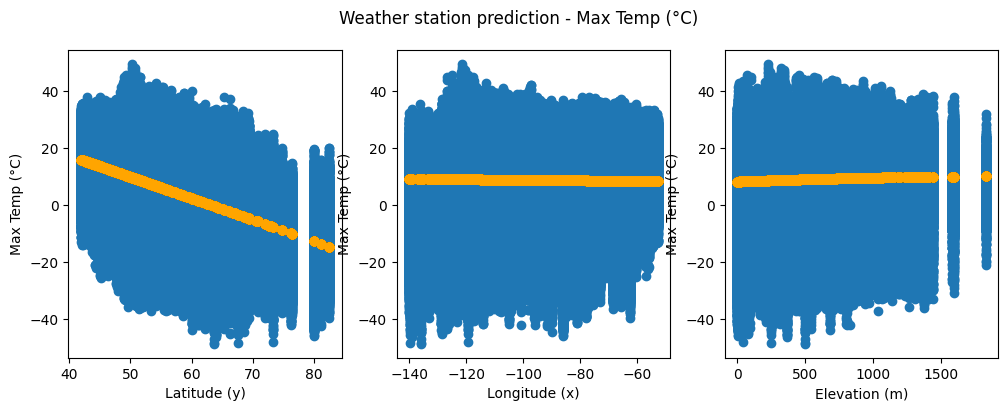

In [19]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize= (12,4))
reg_plot_on_graph(X,y,'Latitude (y)', 1, ax1,to_pred)
reg_plot_on_graph(X,y,'Longitude (x)', 1, ax2,to_pred)
reg_plot_on_graph(X,y,'Elevation (m)', 2, ax3,to_pred)
fig.suptitle(f'Weather station prediction - {to_pred}')
plt.show()

### Base model

Model on: Max Temp (°C) Model score: 0.3935216134894718
Error on temperature measurement 8.392256477440558
0.2859504222869873
Model on: Mean Temp (°C) Model score: 0.41276236577867587
Error on temperature measurement 7.826825276574026
0.2760612964630127
Model on: Min Temp (°C) Model score: 0.4085805187192495
Error on temperature measurement 7.734670238790493
0.2716376781463623
Model on: Total Precip (mm) Model score: 0.02944381614776992
Error on temperature measurement 2.832074171451804
0.2889983654022217


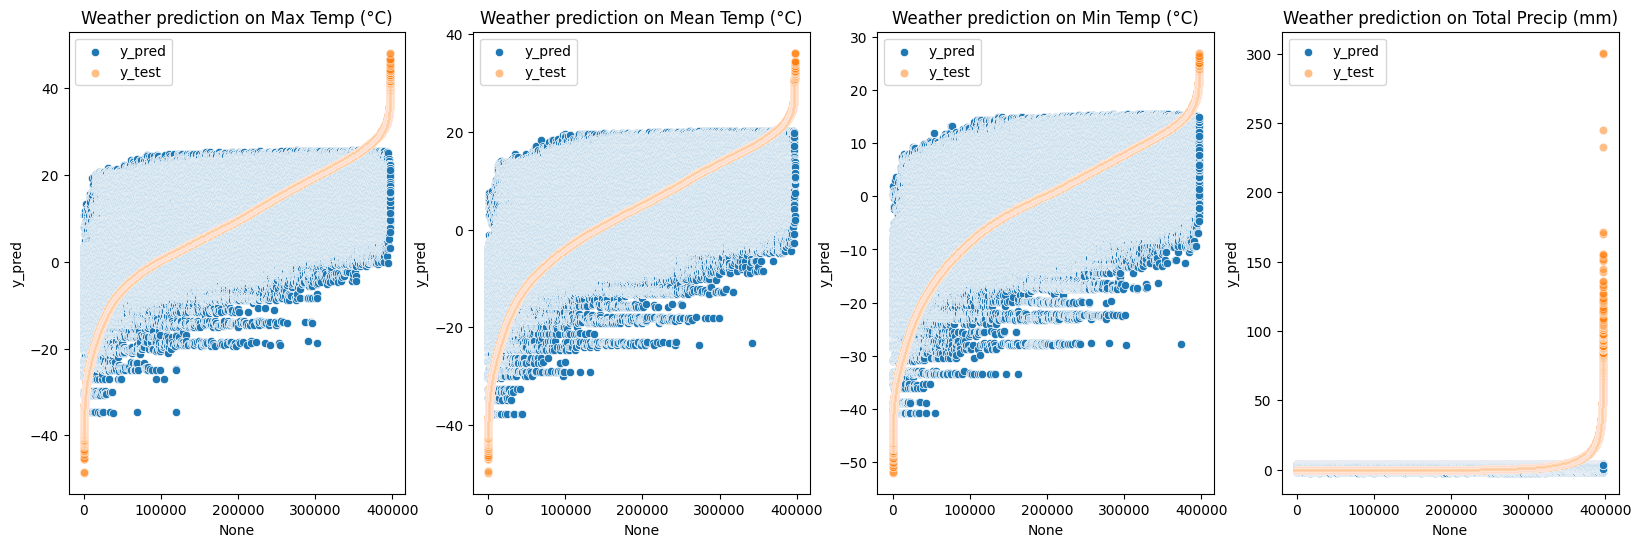

In [20]:
## Lineal regression model : LinearRegression scikit learn without data preprocessing
# Base model

# Linear model on min temp
i = 1
plt.figure(figsize=(20,6))
for pred in pred_list:
    start_time = time.time()
    X = weather_dropna.drop(categorical+['StationId','Date']+drop, axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Building the model
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    delta_time = time.time()-start_time
    result_y['Time (sec)'] = delta_time
    print(delta_time)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()

### Selecting the model

In [21]:
# Storing model trials
result_trial = pd.DataFrame(columns=['Model type','Predictions','Model score','Model absolute error','Time (sec)'])

Model on: Max Temp (°C) Model score: 0.6427515774354338
Error on temperature measurement 6.3479128188399905
0.7727622985839844
Model on: Mean Temp (°C) Model score: 0.6592294599696602
Error on temperature measurement 5.8156801809794985
0.7648706436157227
Model on: Min Temp (°C) Model score: 0.6349505804069504
Error on temperature measurement 5.878827098432022
0.8201766014099121
Model on: Total Precip (mm) Model score: 0.0400972156744811
Error on temperature measurement 2.783357502647026
0.7192316055297852


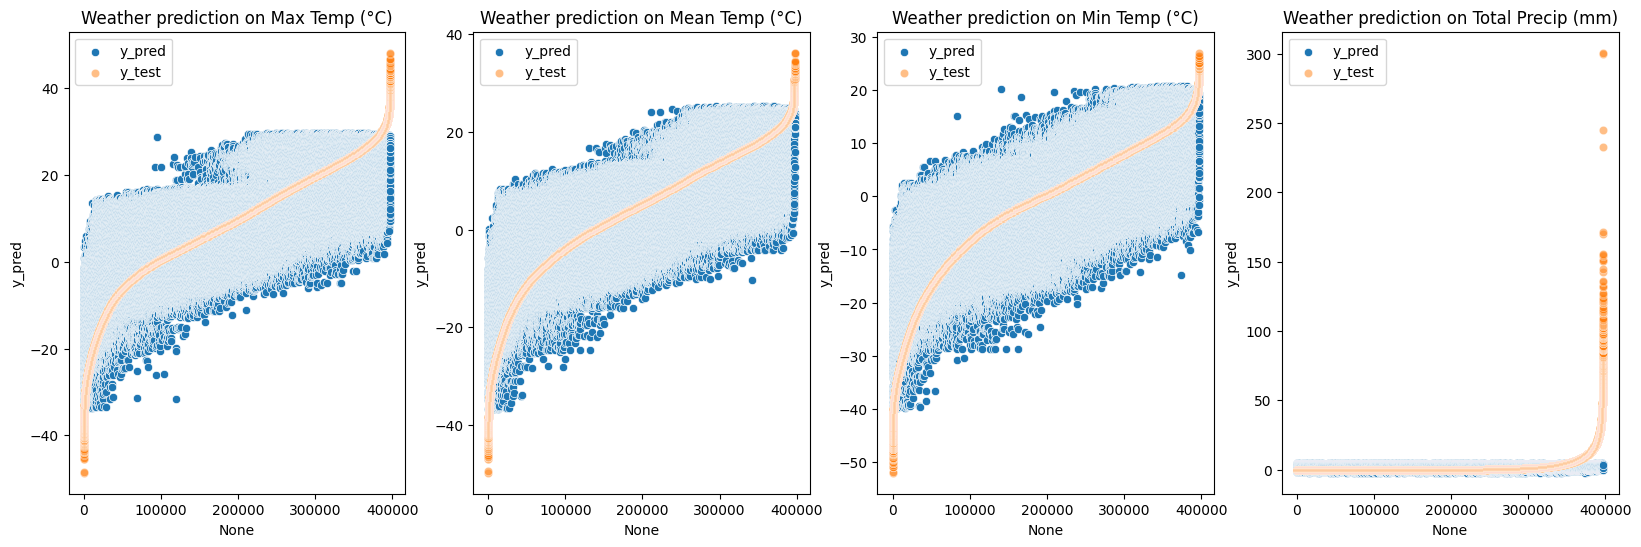

In [22]:
## Lineal regression model : LinearRegression scikit learn
# Linear model on min temp
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                            'Predictions':[pred],
                            'Model score':[model.score(X_test,y_test)],
                            'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()
# Linear model on min temp

Model on: Max Temp (°C) Model score: 0.42929873591591816
Error on temperature measurement 8.105738384150035
0.7224733829498291
Model on: Mean Temp (°C) Model score: 0.440035949023019
Error on temperature measurement 7.601697872482729
0.6535210609436035
Model on: Min Temp (°C) Model score: 0.4227183403314263
Error on temperature measurement 7.545240763252381
0.6011278629302979
Model on: Total Precip (mm) Model score: 0.007755329024544788
Error on temperature measurement 2.88287449538319
0.5641524791717529


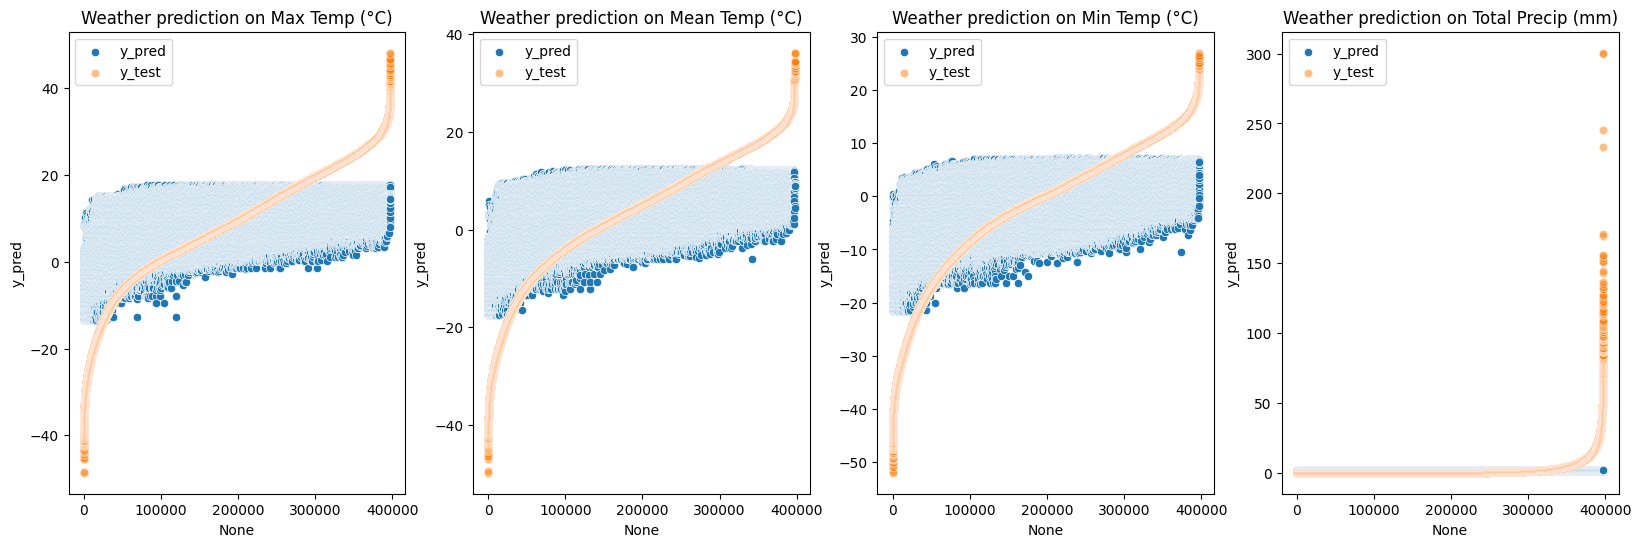

In [23]:
## Lineal regression model : ElasticNet scikit learn
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model = ElasticNet()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                            'Predictions':[pred],
                            'Model score':[model.score(X_test,y_test)],
                            'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()


Model on: Max Temp (°C) Model score: 0.6398562747210221
Error on temperature measurement 6.309065309428498
8.842791318893433
Model on: Mean Temp (°C) Model score: 0.6547406126665509
Error on temperature measurement 5.765808279449983
9.215716361999512
Model on: Min Temp (°C) Model score: 0.6296903404592029
Error on temperature measurement 5.823255845980968
12.43214464187622
Model on: Total Precip (mm) Model score: -0.09037568240624316
Error on temperature measurement 1.9930659780166993
8.815014362335205


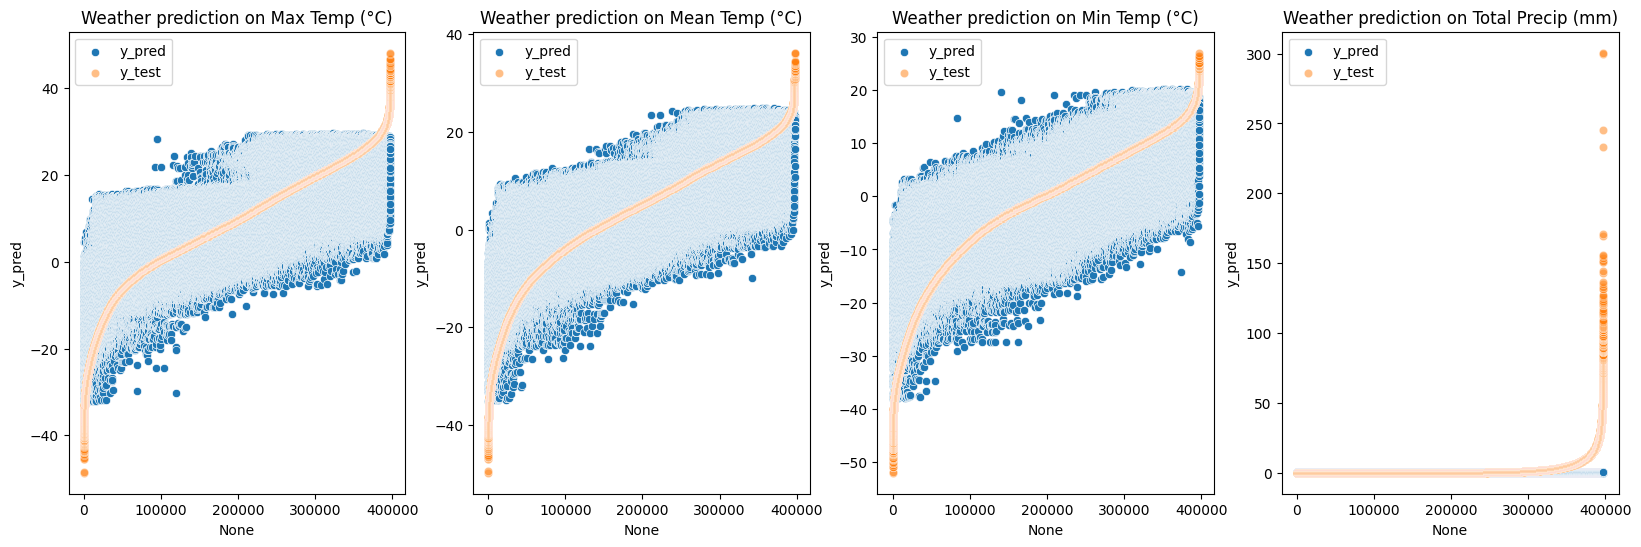

In [24]:
## Lineal regression model : Robust regression scikit learn
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model = HuberRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                                'Predictions':[pred],
                                'Model score':[model.score(X_test,y_test)],
                                'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()



Model on: Max Temp (°C) Model score: 0.9641555173862867
Error on temperature measurement 1.5936514211469892
5.414977073669434
Model on: Mean Temp (°C) Model score: 0.9719483290508852
Error on temperature measurement 1.3903830852285322
5.511822462081909
Model on: Min Temp (°C) Model score: 0.9466787482372523
Error on temperature measurement 1.9153195062748025
5.382009029388428
Model on: Total Precip (mm) Model score: 0.17585335033438443
Error on temperature measurement 1.8133296738714422
5.127506494522095


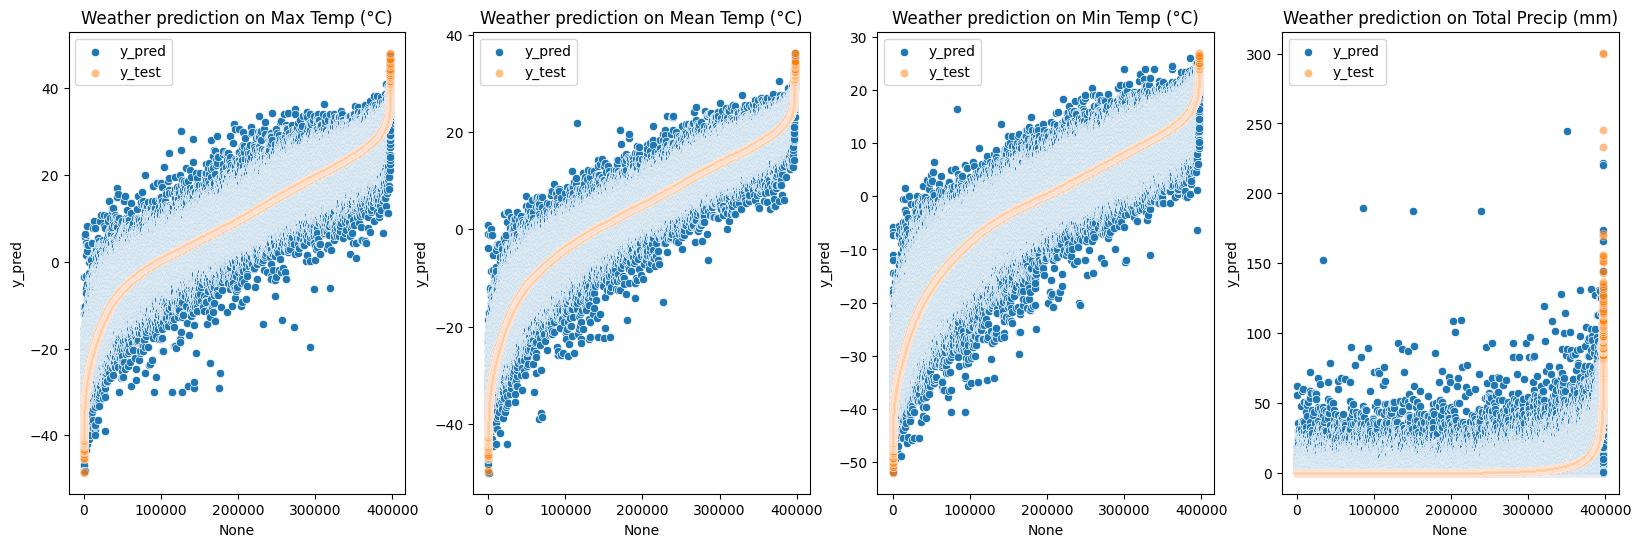

In [25]:
## Lineal regression model : Classifier regressor with Decision Tree regressor scikit learn
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model =  DecisionTreeRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                                'Predictions':[pred],
                                'Model score':[model.score(X_test,y_test)],
                                'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()


Model on: Max Temp (°C) Model score: 0.9806057499142072
Error on temperature measurement 1.281014464469585
371.8939416408539
Model on: Mean Temp (°C) Model score: 0.9848049471258318
Error on temperature measurement 1.0999275852364563
363.3700759410858
Model on: Min Temp (°C) Model score: 0.970981759716285
Error on temperature measurement 1.5114057157006144
340.5608744621277
Model on: Total Precip (mm) Model score: 0.5391025326074292
Error on temperature measurement 1.630623090398636
316.4826726913452


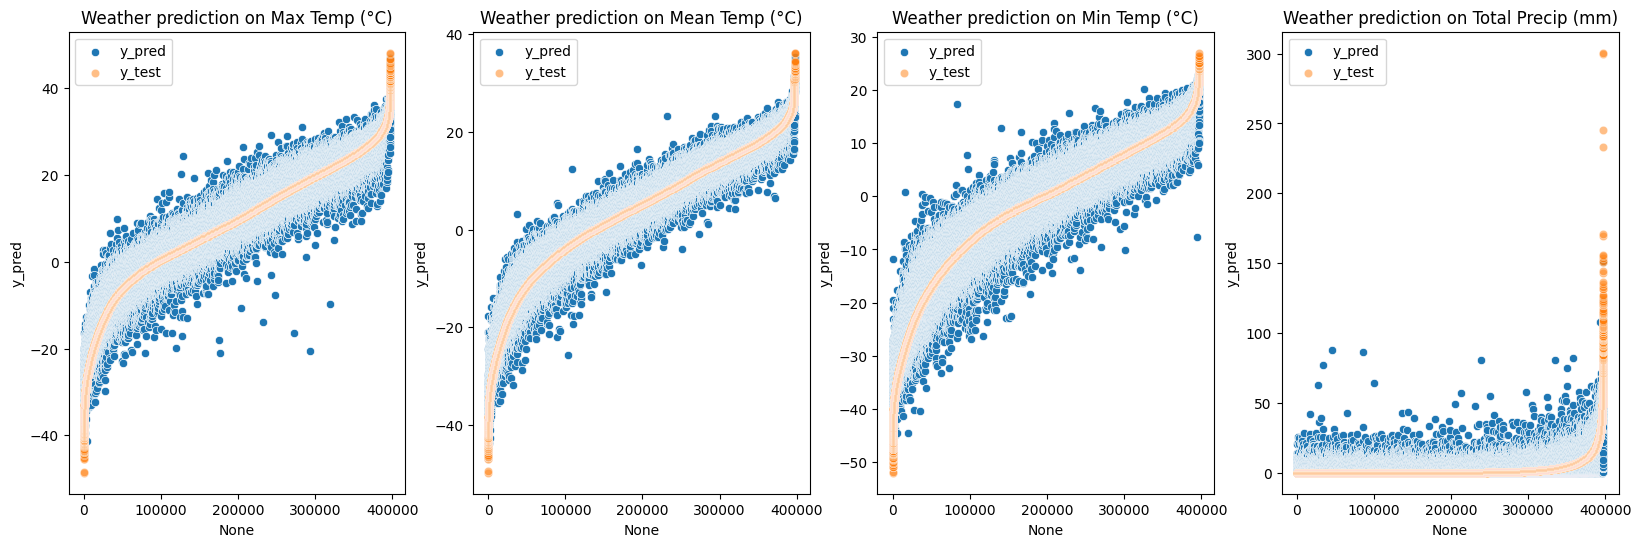

In [26]:
## Lineal regression model : Classifier regressor with Random forest regressor scikit learn
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model =  RandomForestRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                                'Predictions':[pred],
                                'Model score':[model.score(X_test,y_test)],
                                'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()


In [75]:
## Random forest is very long to run, but give the best result.

Model on: Max Temp (°C) Model score: 0.8911979731464245
Error on temperature measurement 3.450715996280222
2.8333988189697266
Model on: Mean Temp (°C) Model score: 0.9070801484266617
Error on temperature measurement 2.958765526368009
2.859131336212158
Model on: Min Temp (°C) Model score: 0.8848825488335794
Error on temperature measurement 3.215883859017771
2.589822769165039
Model on: Total Precip (mm) Model score: 0.1915550627357543
Error on temperature measurement 2.4877123647288637
2.9361934661865234


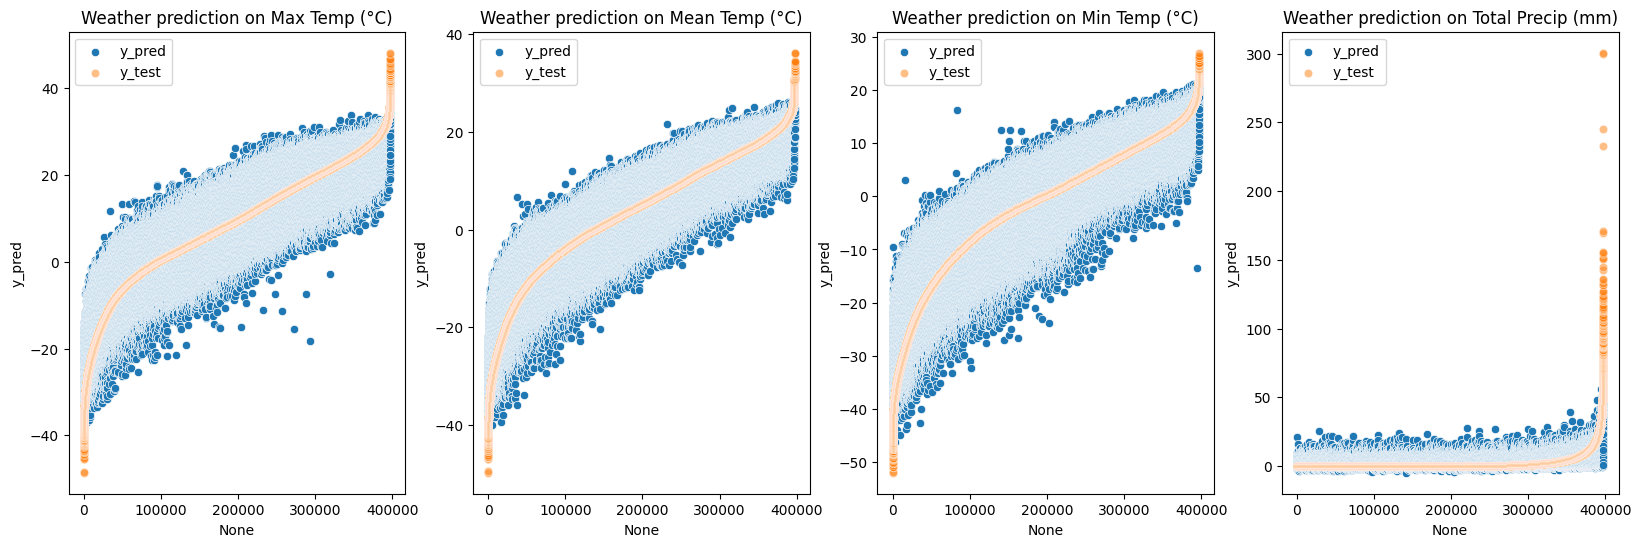

In [27]:
## Lineal regression model : Classifier regressor with XGBoost
i = 1
plt.figure(figsize=(20,6))

for pred in pred_list:
    start_time = time.time()
    X = data_pre.drop(['StationId','Date'], axis=1)
    y = weather_dropna[pred]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model
    model =  XGBRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model on:', pred, 'Model score:', model.score(X_test,y_test))
    print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))
    result = pd.DataFrame(data={'Model type':[str(model)],
                                'Predictions':[pred],
                                'Model score':[model.score(X_test,y_test)],
                                'Model absolute error':[mean_absolute_error(y_test, y_pred)] })
    delta_time = time.time()-start_time
    result['Time (sec)'] = delta_time
    print(delta_time)
    result_trial = pd.concat([result_trial, result], axis=0)
    result_y = pd.DataFrame(data={'y_test':y_test,'y_pred':y_pred}).sort_values(by='y_test').reset_index(drop=True)
    plt.subplot(1,4,i)
    sns.scatterplot(x=result_y.index,y=result_y['y_pred'], label='y_pred' )
    sns.scatterplot(x=result_y.index, y=result_y['y_test'], palette='red', alpha=0.5,label='y_test')
    plt.title(f'Weather prediction on {pred}')
    i+=1
plt.show()


In [103]:
## Neural net regression with the Total precipitation as it is the metric that is performing poorly
# https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
pred = pred_list[3]
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'r2_score'])
# NN_model.summary()

NN_model.fit(X_train,y_train, epochs=200, batch_size=32, validation_split= 0.2)
y_pred = NN_model.predict(X_test)
print('Model on:', pred, 'Model score:', NN_model.score(X_test,y_test))
print('Error on temperature measurement',mean_absolute_error(y_test, y_pred))

#https://medium.com/themlblog/multivariate-regression-using-deep-neural-networks-in-tensorflow-f94f42a148b3

Epoch 1/200
23167/23167 ━━━━━━━━━━━━━━━━━━━━ 15s 571us/step - loss: 1.9569 - mean_absolute_error: 1.9569 - r2_score: -0.0815 - val_loss: 1.9288 - val_mean_absolute_error: 1.9288 - val_r2_score: -0.0601
Epoch 2/200
23167/23167 ━━━━━━━━━━━━━━━━━━━━ 13s 579us/step - loss: 1.9247 - mean_absolute_error: 1.9247 - r2_score: -0.0648 - val_loss: 1.9239 - val_mean_absolute_error: 1.9239 - val_r2_score: -0.0542
Epoch 3/200
23167/23167 ━━━━━━━━━━━━━━━━━━━━ 14s 592us/step - loss: 1.9428 - mean_absolute_error: 1.9428 - r2_score: -0.0577 - val_loss: 1.9183 - val_mean_absolute_error: 1.9183 - val_r2_score: -0.0646
Epoch 4/200
23167/23167 ━━━━━━━━━━━━━━━━━━━━ 12s 512us/step - loss: 1.9215 - mean_absolute_error: 1.9215 - r2_score: -0.0529 - val_loss: 1.9183 - val_mean_absolute_error: 1.9183 - val_r2_score: -0.0473
Epoch 5/200
23167/23167 ━━━━━━━━━━━━━━━━━━━━ 12s 512us/step - loss: 1.9365 - mean_absolute_error: 1.9365 - r2_score: -0.0502 - val_loss: 1.9134 - val_mean_absolute_error: 1.9134 - val_r2_score

KeyboardInterrupt: 

In [28]:
result_trial = result_trial.sort_values(by='Model score', ascending=False)
result_trial
# result_trial.loc[result_trial['Predictions'] == 'Total Precip (mm)']

# The best performing model is the RandomForestRegressor() but it is very long to run... not far behind we have DecisionTreeRegressor() 
# which is running much faster. For Max and Mean, let's try fine tuning DecisionTree
# For Min, let's try fine tuning both RandomFOrest and DecisionTree
# For Total precipitation, we need to take the Random Forest. Other models are very far in score


,Model type,Predictions,Model score,Model absolute error,Time (sec)
0,RandomForestRegressor(),Mean Temp (°C),0.984805,1.099928,363.370076
0,RandomForestRegressor(),Max Temp (°C),0.980606,1.281014,371.893942
0,DecisionTreeRegressor(),Mean Temp (°C),0.971948,1.390383,5.511822
0,RandomForestRegressor(),Min Temp (°C),0.970982,1.511406,340.560874
0,DecisionTreeRegressor(),Max Temp (°C),0.964156,1.593651,5.414977
0,DecisionTreeRegressor(),Min Temp (°C),0.946679,1.915320,5.382009
0,"XGBRegressor(base_score=None, booster=None, ca...",Mean Temp (°C),0.907080,2.958766,2.859131
0,"XGBRegressor(base_score=None, booster=None, ca...",Max Temp (°C),0.891198,3.450716,2.833399
0,"XGBRegressor(base_score=None, booster=None, ca...",Min Temp (°C),0.884883,3.215884,2.589823
0,LinearRegression(),Mean Temp (°C),0.659229,5.815680,0.764871


In [29]:
# Hyperparameter finetuning using gridsearch
## Max temperature
pred = pred_list[0]
print(pred)
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipe = Pipeline([
    ('tree', DecisionTreeRegressor())
])

param_grid = [{
    #'tree__criterion': ['squared_error','friedman_mse'],#,'absolute_error', 'poisson'],
    #'tree__splitter': ['best','random'],
    'tree__max_depth':[None, 300, 500],
    'tree__min_samples_split':[3,5,10],#,10, 20],
    'tree__min_samples_leaf':[3,5]
    #'tree__ccp_alpha':[0,0.002]
        }]

grid_max = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
grid_max.fit(X_train, y_train)
print('Grid Search best score= ',grid_max.best_score_)
print('Best parameters = ', grid_max.best_params_)
model_max = grid_max.best_estimator_
yfit = model_max.predict(X_test)
print('Model on:', pred, 'Model score:', model_max.score(X_test,y_test))

Max Temp (°C)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   3.1s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   3.1s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   3.1s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   3.0

In [30]:
# Hyperparameter finetuning using gridsearch
## Mean temperature
pred = pred_list[1]
print(pred)
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipe = Pipeline([
    ('tree', DecisionTreeRegressor())
])

param_grid = [{
    #'tree__criterion': ['squared_error','friedman_mse'],#,'absolute_error', 'poisson'],
    #'tree__splitter': ['best','random'],
    'tree__max_depth':[None, 300, 500],
    'tree__min_samples_split':[3,5,10],#,10, 20],
    'tree__min_samples_leaf':[3,5]
    #'tree__ccp_alpha':[0,0.01]
        }]

grid_mean = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
grid_mean.fit(X_train, y_train)
print('Grid Search best score= ',grid_mean.best_score_)
print('Best parameters = ', grid_mean.best_params_)
model_mean = grid_mean.best_estimator_
yfit = model_mean.predict(X_test)
print('Model on:', pred, 'Model score:', model_mean.score(X_test,y_test))

Mean Temp (°C)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=3; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=3, tree__min_samples_split=5; total time=   2.

In [31]:
# Hyperparameter finetuning using gridsearch
## Min temperature - Decision tree
pred = pred_list[2]
print(pred)
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipe = Pipeline([
    ('tree', DecisionTreeRegressor())
])

param_grid = [{
    #'tree__criterion': ['squared_error','friedman_mse'],#,'absolute_error', 'poisson'],
    #'tree__splitter': ['best','random'],
    'tree__max_depth':[None, 300, 500],
    'tree__min_samples_split':[3,5,10],#,10, 20],
    'tree__min_samples_leaf':[1,3,5]
    #'tree__ccp_alpha':[0,0.01]
        }]

grid_min = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
grid_min.fit(X_train, y_train)
print('Grid Search best score= ',grid_min.best_score_)
print('Best parameters = ', grid_min.best_params_)
model_min = grid_min.best_estimator_
yfit = model_min.predict(X_test)
print('Model on:', pred, 'Model score:', model_min.score(X_test,y_test))

Min Temp (°C)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=3; total time=   3.0s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time=   2.8s
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time=   2.

In [229]:
# Hyperparameter finetuning using gridsearch
## Min temperature - random forest
pred = pred_list[2]
print(pred)
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipe = Pipeline([
    ('tree', RandomForestRegressor())
])

param_grid = [{
    #'tree__criterion': ['squared_error','friedman_mse'],#,'absolute_error', 'poisson'],
    #'tree__splitter': ['best','random'],
    'tree__max_depth':[None, 300],
    'tree__min_samples_split':[2,5],#,10, 20],
    'tree__min_samples_leaf':[1,3],
    #'tree__ccp_alpha':[0,0.01]
        }]

grid_min2 = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
grid_min2.fit(X_train, y_train)
print('Grid Search best score= ',grid_min2.best_score_)
print('Best parameters = ', grid_min2.best_params_)
model_min2 = grid_min2.best_estimator_
yfit = model_min2.predict(X_test)
print('Model on:', pred, 'Model score:', model_min2.score(X_test,y_test))

Min Temp (°C)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.8min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.7min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.7min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.7min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.9min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.3min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.3min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.3min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.3min

In [231]:
# Hyperparameter finetuning using gridsearch
## Total precipitation - random forest
pred = pred_list[3]
print(pred)
X = data_pre.drop(['StationId','Date'], axis=1)
y = weather_dropna[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipe = Pipeline([
    ('tree', RandomForestRegressor())
])

param_grid = [{
    #'tree__criterion': ['squared_error','friedman_mse'],#,'absolute_error', 'poisson'],
    #'tree__splitter': ['best','random'],
    'tree__max_depth':[None, 300],
    'tree__min_samples_split':[2,5],#,10, 20],
    'tree__min_samples_leaf':[1,3],
    #'tree__ccp_alpha':[0,0.01]
        }]

grid_prec = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
grid_prec.fit(X_train, y_train)
print('Grid Search best score= ',grid_prec.best_score_)
print('Best parameters = ', grid_prec.best_params_)
model_prec = grid_prec.best_estimator_
yfit = model_prec.predict(X_test)
print('Model on:', pred, 'Model score:', model_prec.score(X_test,y_test))

Total Precip (mm)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 4.0min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.9min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.9min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.7min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=2; total time= 3.7min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.5min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.5min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.4min
[CV] END tree__max_depth=None, tree__min_samples_leaf=1, tree__min_samples_split=5; total time= 3.

## Final models

In [32]:
X = data_pre.drop(['StationId','Date'], axis=1)

y =weather_dropna['Max Temp (°C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_max.fit(X_train,y_train)
y_pred = model_max.predict(X_test)
print('Max Temp (°C)')
print('Model best parameters', grid_max.best_params_)
print('mean_absolute_error',np.sqrt(mean_absolute_error(y_test, y_pred)))
print('R2',model_max.score(X_test, y_test))


y =weather_dropna['Mean Temp (°C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_mean.fit(X_train,y_train)
y_pred = model_mean.predict(X_test)
print('Mean Temp (°C)')
print('Model best parameters', grid_mean.best_params_)
print('mean_absolute_error',np.sqrt(mean_absolute_error(y_test, y_pred)))
print('R2',model_mean.score(X_test, y_test))

y =weather_dropna['Min Temp (°C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_min.fit(X_train,y_train)
y_pred = model_min.predict(X_test)
print('Min Temp (°C)')
print('Model best parameters', grid_min.best_params_)
print('mean_absolute_error',np.sqrt(mean_absolute_error(y_test, y_pred)))
print('R2',model_min.score(X_test, y_test))


Max Temp (°C)
Model best parameters {'tree__max_depth': None, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 3}
mean_absolute_error 1.2523985232555273
R2 0.9693617719822242
Mean Temp (°C)
Model best parameters {'tree__max_depth': 500, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 5}
mean_absolute_error 1.1679183441043786
R2 0.975485821023986
Min Temp (°C)
Model best parameters {'tree__max_depth': 300, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 3}
mean_absolute_error 1.360031760910676
R2 0.9551459222647186


In [ ]:
# y =weather_dropna['Min Temp (°C)']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model_min2.fit(X_train,y_train)
# y_pred = model_min2.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, y_pred)))
# print(model_min2.score(X_test, y_test))


# y =weather_dropna['Total Precip (mm)']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model_prec.fit(X_train,y_train)
# y_pred = model_prec.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, y_pred)))
# print(model_prec.score(X_test, y_test))


## Export model

In [33]:
# Max temp with dill
data = {"model": model_max,'encoder':encoder,'scaler':scaler, 'columns':dict_columns}
with open('model_maxtemp_dill.dill', 'wb') as file:
    dill.dump(data,file)

In [34]:
# Mean temp with dill
data = {"model": model_mean,'encoder':encoder,'scaler':scaler, 'columns':dict_columns}
with open('model_meantemp_dill.dill', 'wb') as file:
    dill.dump(data,file)

In [35]:
# Min temp with dill
data = {"model": model_min,'encoder':encoder,'scaler':scaler, 'columns':dict_columns}
with open('model_mintemp_dill.dill', 'wb') as file:
    dill.dump(data,file)

In [41]:
# # Total precipitation
# data = {"model": model_prec,'encoder':encoder,'scaler':scaler, 'columns':dict_columns}
# with open('model_totalprec.pkl', 'wb') as file:
#     pickle.dump(data,file)

## Validate saved models

In [42]:
weather1 = weather1.loc[weather1['Elevation (m)'].isnull()==False].reset_index(drop=True)
test_model = weather1.loc[weather1['Max Temp (°C)'].isnull()==False].reset_index(drop=True)
data = test_model.drop(drop, axis=1)

## Adding null value validation
# encoder
data_enc = encoder.transform(data[categorical])
data2 = data.drop(categorical, axis=1)
columns_encode = encoder.get_feature_names_out()
data_enc2 = pd.DataFrame(data=data_enc, columns=columns_encode)
data3 = pd.concat([data2,data_enc2], axis=1)
data3
# scaler
data3[numerical]= scaler.transform(data3[numerical])
X=data3.drop(['StationId','Date'],axis=1)
y=test_model['Max Temp (°C)']
y_pred = model_max.predict(X)
print('Measurement prediction (real vs predicted):', y[0], y_pred[0])
print('Error on temperature measurement',mean_absolute_error(y, y_pred))
test_model.iloc[0]

Measurement prediction (real vs predicted): -11.0 -9.719999999999999
Error on temperature measurement 1.066445147496682


Province                    NEWFOUNDLAND
StationId                          52541
Station Name                    WABUSH A
Longitude (x)                     -66.86
Latitude (y)                       52.92
Year                                2024
Season                            Winter
Season_num                             1
Month                                  1
Day                                    1
Max Temp (°C)                      -11.0
Min Temp (°C)                      -21.5
Mean Temp (°C)                     -16.3
Total Precip (mm)                    0.2
Elevation (m)                      551.4
Date                 2024-01-01 00:00:00
Name: 0, dtype: object

In [43]:
weather1 = weather1.loc[weather1['Elevation (m)'].isnull()==False].reset_index(drop=True)
test_model = weather1.loc[weather1['Mean Temp (°C)'].isnull()==False].reset_index(drop=True)
data = test_model.drop(drop, axis=1)

## Adding null value validation
# encoder
data_enc = encoder.transform(data[categorical])
data2 = data.drop(categorical, axis=1)
columns_encode = encoder.get_feature_names_out()
data_enc2 = pd.DataFrame(data=data_enc, columns=columns_encode)
data3 = pd.concat([data2,data_enc2], axis=1)

# scaler
data3[numerical]= scaler.transform(data3[numerical])

X=data3.drop(['StationId','Date'],axis=1)
y=test_model['Mean Temp (°C)']
y_pred = model_mean.predict(X)
print('Measurement prediction (real vs predicted):', y[0], y_pred[0])
print('Error on temperature measurement',mean_absolute_error(y, y_pred))
test_model.iloc[0]

Measurement prediction (real vs predicted): -16.3 -14.6
Error on temperature measurement 0.9034357895982102


Province                    NEWFOUNDLAND
StationId                          52541
Station Name                    WABUSH A
Longitude (x)                     -66.86
Latitude (y)                       52.92
Year                                2024
Season                            Winter
Season_num                             1
Month                                  1
Day                                    1
Max Temp (°C)                      -11.0
Min Temp (°C)                      -21.5
Mean Temp (°C)                     -16.3
Total Precip (mm)                    0.2
Elevation (m)                      551.4
Date                 2024-01-01 00:00:00
Name: 0, dtype: object

In [44]:
weather1 = weather1.loc[weather1['Elevation (m)'].isnull()==False].reset_index(drop=True)
test_model = weather1.loc[weather1['Min Temp (°C)'].isnull()==False].reset_index(drop=True)
data = test_model.drop(drop, axis=1)

## Adding null value validation
# encoder
data_enc = encoder.transform(data[categorical])
data2 = data.drop(categorical, axis=1)
columns_encode = encoder.get_feature_names_out()
data_enc2 = pd.DataFrame(data=data_enc, columns=columns_encode)
data3 = pd.concat([data2,data_enc2], axis=1)

# scaler
data3[numerical]= scaler.transform(data3[numerical])

X=data3.drop(['StationId','Date'],axis=1)
y=test_model['Min Temp (°C)']
y_pred = model_min.predict(X)
print('Measurement prediction (real vs predicted):', y[0], y_pred[0])
print('Error on temperature measurement',mean_absolute_error(y, y_pred))
test_model.iloc[0]


Measurement prediction (real vs predicted): -21.5 -20.974999999999998
Error on temperature measurement 1.3005221225388999


Province                    NEWFOUNDLAND
StationId                          52541
Station Name                    WABUSH A
Longitude (x)                     -66.86
Latitude (y)                       52.92
Year                                2024
Season                            Winter
Season_num                             1
Month                                  1
Day                                    1
Max Temp (°C)                      -11.0
Min Temp (°C)                      -21.5
Mean Temp (°C)                     -16.3
Total Precip (mm)                    0.2
Elevation (m)                      551.4
Date                 2024-01-01 00:00:00
Name: 0, dtype: object

In [45]:

with zipfile.ZipFile("model_maxtemp_dill.zip", "r") as zip_ref:
    with zip_ref.open("model_maxtemp_dill.dill", "r") as file:
        data = dill.load(file)

# Switch to dill, error with pickle in streamlit
#https://medium.com/@tristenwallace/how-to-pickle-functions-from-within-main-a480aadb3833

regressor_max = data["model"]
encoder_extract = data["encoder"]
scaler_extract = data["scaler"]
columns_extract = data['columns']
columns_extract.keys()

dict_keys(['Categorical', 'Ordinal', 'Continuous', 'Numerical', 'drop'])

In [46]:
test_model = weather1.loc[weather1['Max Temp (°C)'].isnull()==False].reset_index(drop=True)
data = test_model.drop(columns_extract['drop'], axis=1)
# encoder
data_enc = encoder_extract.transform(data[columns_extract['Categorical']])
data2 = data.drop(columns_extract['Categorical'], axis=1)
columns_encode = encoder_extract.get_feature_names_out()
data_enc2 = pd.DataFrame(data=data_enc, columns=columns_encode)
data3 = pd.concat([data2,data_enc2], axis=1)
data3
# scaler
data3[columns_extract['Numerical']]= scaler_extract.transform(data3[columns_extract['Numerical']])
X=data3.drop(['StationId','Date'],axis=1)
y=test_model['Max Temp (°C)']
y_pred = regressor_max.predict(X)
print('Measurement prediction (real vs predicted):', y[0], y_pred[0])
print('Error on temperature measurement',mean_absolute_error(y, y_pred))

## Same result as the inital model

Measurement prediction (real vs predicted): -11.0 -9.719999999999999
Error on temperature measurement 1.0665522126828264
